# Understanding the Amazon rainforest from space

Project Objective: https://docs.google.com/document/d/1PndRvSS1VFS65k9Bc9NEJe2TXQS8ijQKxhcIQ0KpxMA/edit

Project Slides: https://docs.google.com/presentation/d/1u1-tLjdER-5VXgWX8vkGAc44Ci-0TVz-gJyqxecEx2M/edit#slide=id.p1

Overview of Assignment
There are three types of tags in this assignment:
<br>
1) Weather (Cloudly, Partly Cloudy, Hazy, Clear) - every item has only one of these ones
<br>
2) Easy to identify tags Primary (forest), agricultural, habitation, roads, water, cultivation, bare ground,
<br>
3) Hard Labels - Slash & Burn, selective logging, blooms, and mine types
<br>

Given we are mostly interested in being able to tell where deforestation is occuring, we will simplify the land tags into naturally occuring phenomena. We will also analyse the weather tags because knowing whether we can't see forest due to deforestation or due to clouds is important.



In [24]:
##Create Libraries [Requires cleaning]
### Required libraries

import numpy as np # linear algebra
import pandas as pd 
from collections import Counter, defaultdict
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import scipy.stats
import seaborn as sns
import cv2
import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls
import random
import math
# from osgeo import gdal
from skimage import io
#import imageio
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

## Pipeline Setup for Data Preprocessing

There are several steps for data preprocessing:

**Step 1: Import Labels and Read in the Satellite Images.**

There're 2 image formats provided for training and testing: jpg and tif. The tif format contains additional dimensions outside of the jpg RGB dimensional constraints which enable us to extract the infrared spectrum.
Sub-steps:
Build functions to:
*     a) Read labels and create relevant ones
*     b) Read JPG Images 
*     c) Read Tif Images
*     d) extract statistical information for analyses

We then need to e) Run all of the above

**Step 2: Label Analysis**

Each picture can have multiple labels. There is a varying visibility between the images.  

As a result, visibility is a key feature which needs to be identified and cleared for additional feature identification. Visibility is categorized in levels by cloud cover - haze, partly cloudy, cloudy and clear.

Since the goal of our project is to automatically categorize landscape, which prepares for the prediction of rainforest diminishing rate, we categorize the original labels into three main areas:
* Weather due to cloud cover (haze, partly cloudy, haze)
* Water: rivers and large water bodies
* Primary: primary rainforest
* Other tags

All other tags will be combined under "Other tags" to reduce the complexity.

**Step 3: Image Color Detection**

Static features, including volume of colours, can be extracted using the following logic:
* Green = Trees/Vegetation
* Blue = Water
* White = Clouds

The higher the pixel value, the higher the intensity of the colors. Variance in the colors indicate feature differences in the image.

Water features can be identified by removing the blue frequency from the near-infrared spectrum: (B-IRR)/(B+IRR) 

Vegetation features can be identified by removing green frequency from the near-infrared spectrum: (IRR-R)/(R+IRR). 

**Step 4: Image Edge Detection**

Edge detection in the images can be analyzed using the following parameters:
* Laplacian outputs the color gradients in the images
* Sobel outputs the edges of the color gradients in the x or the y directions

The majority of the pictures may not have large color gradients. As a result, many of the images are dominated by their respective label components and relatively few satellite images contain edges.

**Step 5: Form a Combined Dataset**

After completing Color and Edge detection, we concatenate the two new dataframes to form the final combined dataframe.

**Step 6: Split Training and Testing Dataset**

To predict weather and land seperatly, we randomly split the combined dataset twice to form the test and training data for weather as well as testing and training data for land

# 1a) Import Labels

In [25]:
#Add a column for land tags
def apply_land(land_tags):
    land_list=[]
    other_tags=['habitation','bare_ground','cultivation','agriculture','blow_down', 'conventional_mine', 'selective_logging', 'slash_burn', 'artisinal_mine', 'blooming']
    if 'primary' in land_tags:
        land_list.append('primary')
    if 'water' in land_tags:
        land_list.append("water")
    other_present=0
    for i in other_tags:
        if i in land_tags:
            other_present=1
            break
    if other_present==1:
        land_list.append('other')
    if land_list == []:
        land_list.append('none')
    return ' '.join(land_list)

#Add a column for weather tags
def apply_weather(weather):
    if 'partly_cloudy' in weather:
        return 'partly_cloudy'
    elif 'cloudy' in weather:
        return 'cloudy'
    elif 'haze' in weather:
        return 'haze'
    else:
        return 'clear'

#create both columns, and a third with a third columns
      
def add_three_columns(df):
    df['weather'] = df.tags.map(apply_weather)
    df['land'] = df.tags.map(apply_land)
    df['combined'] = df[['weather', 'land']].apply(lambda x: ''.join(x), axis=1)
    return df

#read the data
df = pd.read_csv('train_labels.csv')
# create our labels
add_three_columns(df)
#save the results for 
df.to_csv("train_labels_clean.csv")


# 1b) Read jpg Data
## Create haze remover to improve the features of the jpgs

In [32]:
##Hi june - We didn't build this so please don't count the design in our marking. 
# It's just being used to improve the extraction of land features of pictures with haze.
# Kaiming He, Jian Sun, and Xiaoou Tang, »Single Image Haze Removal
# Using Dark Channel Prior« in IEEE Transactions on Pattern Analysis
# and Machine Intelligence, vol. 33, no. 12, 2341--2353 (2010)
# DOI:  10.1109/TPAMI.2010.168

def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz,1);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
        atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz):
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return res


def remove_haze(image):
    src = cv2.imread(image);
    I = src.astype('float64')/255;
    dark = DarkChannel(I,15);
    A = AtmLight(I,dark);
    te = TransmissionEstimate(I,A,15);
    t = TransmissionRefine(src,te);
    J = Recover(I,t,A,0.1);
    return J

## Read all of the jpg data

In [27]:
##set paths for images
train_path1='train_jpg/'
train_path2='train_tif/'

##reads pre and post haze removal images
def read_image(image_str):
    ##read the image
    read_img = plt.imread(train_path1+image_str)
    read_img=read_img[:,:,:3]
    ##reduce the image size for smaller processing
    jpg_img=transform.resize(read_img, (64,64,3))
    ##use the remove haze image to better identify features
    haze_img=remove_haze(train_path1+image_str)
    haze_img=transform.resize(haze_img, (64,64,3))
    ##create a matrix for both features
    clean_img=np.zeros((64,64,6))
    clean_img[:,:,:3]=jpg_img
    clean_img[:,:,3:6]=haze_img
    return clean_img

#loop to read all of ht eimages
def read_image_loop():
    #retrieve jpg data - compress from 256x256 to 64x64 for faster training [remove constraint in final product]
    data_jpgs=np.zeros((df.shape[0],64,64,11))
    for i in range(df.shape[0]):
        data_jpgs[i,:,:,0:6]=read_image("train_"+str(i)+".jpg")
    return data_jpgs
        
def add_grey_scale(data_jpgs):
    ##add - greyscale information for both normal images
    data_jpgs[:,:,:,6]=data_jpgs[:,:,:,0]*0.2989+data_jpgs[:,:,:,1]*0.5870+data_jpgs[:,:,:,2]*0.1140
    ##add - greyscale information for haze images
    data_jpgs[:,:,:,7]=data_jpgs[:,:,:,3]*0.2989+data_jpgs[:,:,:,4]*0.5870+data_jpgs[:,:,:,5]*0.1140
    return data_jpgs


## 1C) Read TIF data - extract infra-red data

In [28]:

def extract_identifier(image_str):
    img = io.imread(train_path2+image_str)
    small_img=transform.resize(img, (64,64,4))
    return small_img

def extract_identifier_loop(df):
    #4th dimension of GeoTiff contains near-infrared spectrum
    tif_data=np.zeros((df.shape[0],64,64,4))
    for i in range(df.shape[0]):
        tif_data[i,:,:,:]=extract_identifier("train_"+str(i)+".tif")
    return tif_data
        
def feature_indication(data_jpgs, tif_data):
    
    avg_water_infrared = 0.09
    min_avg_water_infrared = 0.03
    
    for i, j in enumerate(tif_data):
        mean_infrared = tif_data[i,:,:,3].mean()
        if mean_infrared < avg_water_infrared and mean_infrared > min_avg_water_infrared:
            data_jpgs[:,:,:,8] = 1.0
        else:
            data_jpgs[:,:,:,8] = 0.0
    
  
    #This take the infrared pixels, subtracts the red, and divides by the total to indicate vegetation
    data_jpgs[:,:,:,9]=(tif_data[:,:,:,3]-tif_data[:,:,:,2])/(tif_data[:,:,:,3]+tif_data[:,:,:,2]) 
    
    #This take the infrared pixels, subtracts the green, and divides by the total just in case 
    # green and infrared have an interesting relationship
    #data_jpgs[:,:,:,10]=(tif_data[:,:,:,3]-tif_data[:,:,:,1])/(tif_data[:,:,:,3]+tif_data[:,:,:,1]) 
    return data_jpgs
    


#D) create frames towith statistical information 
about all of the colours extracted.
We'll extract the:
* mean
* variance
* standard deviation
* kurtosis
* skew

In addition for the haze free jpgs, and the infrared spectrum, we'll create histograms as a cheating way to store the distribution of these colours.

In [29]:
def extract_jpg_stats(df, data_jpgs):
    ## extract_basic-stats about image
    stats_flat=np.reshape(data_jpgs,(data_jpgs.shape[0],4096,11))    
    jpg_stats=np.zeros((df.shape[0],175))
    ##extract normal stats
    for i in range(stats_flat.shape[0]):
        jpg_stats[i,:11]=np.average(stats_flat[i,:,],axis=0)
        jpg_stats[i,11:22]=np.var(stats_flat[i,:,],axis=0)
        jpg_stats[i,22:33]=np.std(stats_flat[i,:,],axis=0)
        kurt_skew=np.zeros((22,))
        for j in range(6):
            kurt_skew[j]=scipy.stats.kurtosis(data_jpgs[i,:,:,j].ravel())
            kurt_skew[j+11]=scipy.stats.skew(data_jpgs[i,:,:,j].ravel())
        jpg_stats[i,33:55]=kurt_skew
        ##get histograms of colour for haze removed rgb
        for j in range(3):
            start=55+j*20
            end=start+20
            t=np.array(np.histogram(data_jpgs[i,:,:,j+3],bins=20, range=(0,1))[0])
            jpg_stats[i,start:end]=t
        ##get histograms of colour for IRR screens
        for j in range(3):
            start=105+j*20
            end=start+20
            t=np.array(np.histogram(data_jpgs[i,:,:,j+8],bins=20, range=(-1,1))[0])
            jpg_stats[i,start:end]=t
    return jpg_stats

def extract_edge_stats(df, data_jpgs):
    ##extract edge data from images
    edge_stats=np.zeros((df.shape[0],12))
    for i in range(df.shape[0]):
        img=data_jpgs[i,:,:,3:6]
        hazy_img=data_jpgs[i,:,:,0:3]
        edge_stats[i,0]=cv2.Laplacian(img, cv2.CV_64F).mean()
        edge_stats[i,1]=cv2.Laplacian(img, cv2.CV_64F).var()
        edge_stats[i,2]=cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5).var()
        edge_stats[i,3]=cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5).mean()
        edge_stats[i,4]=cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5).mean()
        edge_stats[i,5]=cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5).var()
        ##extract the difference between haze and haze free
        edge_stats[i,6]=cv2.Laplacian(hazy_img, cv2.CV_64F).mean()
        edge_stats[i,7]=cv2.Laplacian(hazy_img, cv2.CV_64F).var()
        edge_stats[i,8]=cv2.Sobel(hazy_img,cv2.CV_64F,1,0,ksize=5).var()
        edge_stats[i,9]=cv2.Sobel(hazy_img,cv2.CV_64F,1,0,ksize=5).mean()
        edge_stats[i,10]=cv2.Sobel(hazy_img,cv2.CV_64F,0,1,ksize=5).mean()
        edge_stats[i,11]=cv2.Sobel(hazy_img,cv2.CV_64F,0,1,ksize=5).var()
    return edge_stats

def new_dataframe_df1(jpg_stats):
    colours=['red','green','blue','red_dehaze','green_dehaze','blue_dehaze','gray','gray_dehaze','water_index','veg_index','other_irr']
    #colours=['red','green','blue','red_dehaze','green_dehaze','blue_dehaze','gray','gray_dehaze','water_index','veg_index']
    operations=['mean','variance','std','kurtosis','skew']
    header_list=[]
    for i in range(len(operations)):
        for j in range(len(colours)):
            string=colours[j]+'_'+operations[i]
            header_list.append(string)
    for j in range(3):
        for i in range(20):
            string=colours[j]+"_hist_bucket_"+str(i)
            header_list.append(string)
    for j in range(3):
        for i in range(20):
            string=colours[j+8]+"_hist_bucket_"+str(i)
            header_list.append(string)
    df1 = pd.DataFrame(jpg_stats[:,:175], columns=header_list)
    return df1

def new_dataframe_df2(edge_stats):
    column_heads=['laplac_mean','laplac_var','sob_mean1','sob_var1','sob_mean2','sob_var2',
                  'laplac_mean_hazy','laplac_var_hazy','sob_mean1_hazy','sob_hazy_var','sob_hazymean_2','sob_hazy_var2']
    df2 = pd.DataFrame(edge_stats, columns=column_heads)
    return df2

def final_dataframe(df1, df2):
    #Combine all of our information into one data set#Combine 
    combined_matrix=pd.concat([df1, df2], axis=1)
    combined_matrix.to_csv("train_data.csv")
    return combined_matrix



## E) Run all of the above funtions

In [ ]:
##jpgs
data_jpgs = read_image_loop()
data_jpgs = add_grey_scale(data_jpgs)

##tif
tif_data = extract_identifier_loop(df)
data_jpgs = feature_indication(data_jpgs, tif_data)

##stats
jpg_stats = extract_jpg_stats(df, data_jpgs)
edge_stats = extract_edge_stats(df, data_jpgs)

##turn into a 
df1 = new_dataframe_df1(jpg_stats)
df2 = new_dataframe_df2(edge_stats)
combined_matrix = final_dataframe(df1, df2)

#we've created a train data
combined_matrix.to_csv('train_data.csv')

## Outputs from Data Preprocessing

#### A quick peek into the data tags

In [10]:
#After adding three more columns, our dataframe looks like this
print(df.iloc[:5])

  image_name                                       tags weather  \
0    train_0                               haze primary    haze   
1    train_1            agriculture clear primary water   clear   
2    train_2                              clear primary   clear   
3    train_3                              clear primary   clear   
4    train_4  agriculture clear habitation primary road   clear   

                  land                  combined  
0              primary               hazeprimary  
1  primary water other  clearprimary water other  
2              primary              clearprimary  
3              primary              clearprimary  
4        primary other        clearprimary other  


#### Graph demonstrations of weather and land types

Image visibility varies. Images with out haze and cloud are much easier to identify the land type.

Each picture has multiple labels except for 'Cloudy' tag, which does not appear with other labels. 'Water' is sometimes hard to identify in the images.

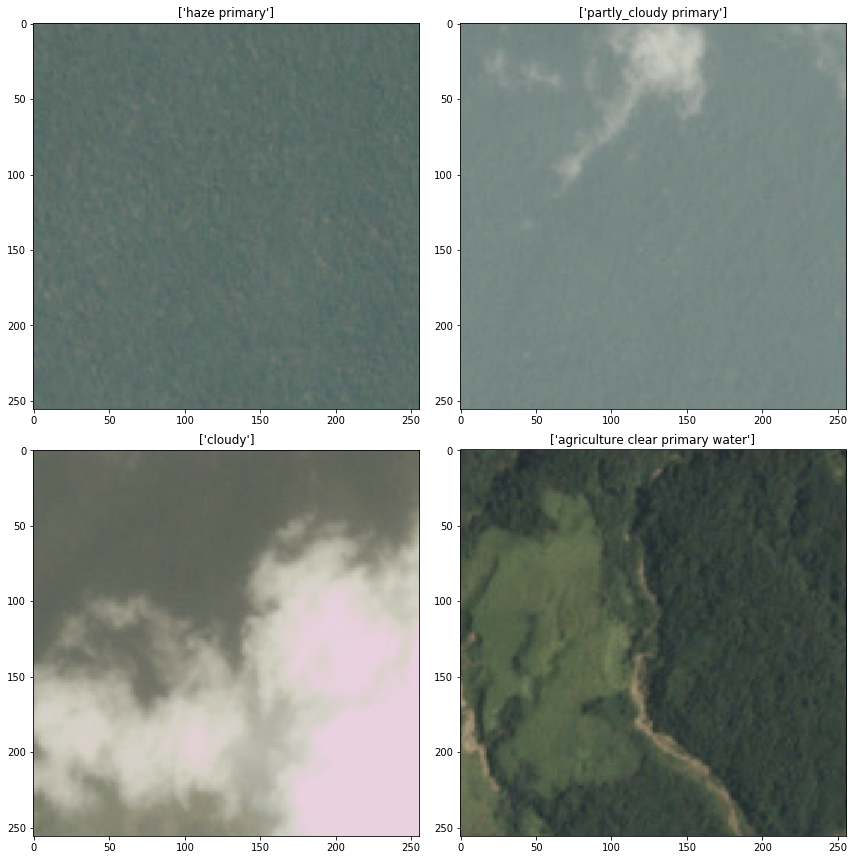

In [30]:
#Graph demonstration of four weather type
plt.figure(figsize=(12,12))
weather_list = ["haze","partly_cloudy","cloudy","clear"]
j = 0
for i in weather_list:
    plt.subplot(2,2,j+1)
    image_number = df.loc[df['weather'] == i][:1]['image_name'].values
    image_path = train_path1+image_number+".jpg"
    plt.imshow(plt.imread(image_path[0]))
    plt.tight_layout()
    plt.title(str(df[df.image_name == image_number[0]].tags.values))  
    j += 1

### Water prediction

Using near-infrared analysis, water can be predicted using the average "temperature" of the image.

Max near-infrared value is:  0.38139543755245287
Min near-infrared value is:  0.010940718699931334
Mean near-infrared value is:  0.09762339834287626
SD near-infrared value is:  0.02784415693613795
Mean & SD water-based near-infrared value are:  0.09113916598105458 0.027277480267102028


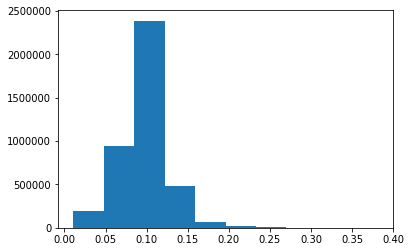

In [197]:
print('Max near-infrared value is: ', tif_data[:,:,:,3].max())
print('Min near-infrared value is: ', tif_data[:,:,:,3].min())
print('Mean near-infrared value is: ', tif_data[:,:,:,3].mean())
print('SD near-infrared value is: ', tif_data[:,:,:,3].std())
plt.hist(tif_data[:,:,:,3].flatten())

water_infrared = []
for i, row in df.iterrows():
    if 'water' in row['land']:
        water_infrared.append(tif_data[i,:,:,3].mean())

        
avg_water_infrared = np.mean(water_infrared)
sd_water_infrared = np.std(water_infrared)
print('Mean & SD water-based near-infrared value are: ', avg_water_infrared, sd_water_infrared)

water_count = 0

for i, j in enumerate(tif_data):
    mean_infrared = tif_data[i,:,:,3].mean()
    if  mean_infrared < avg_water_infrared and mean_infrared > (avg_water_infrared - 2*sd_water_infrared):
        water_count += 1

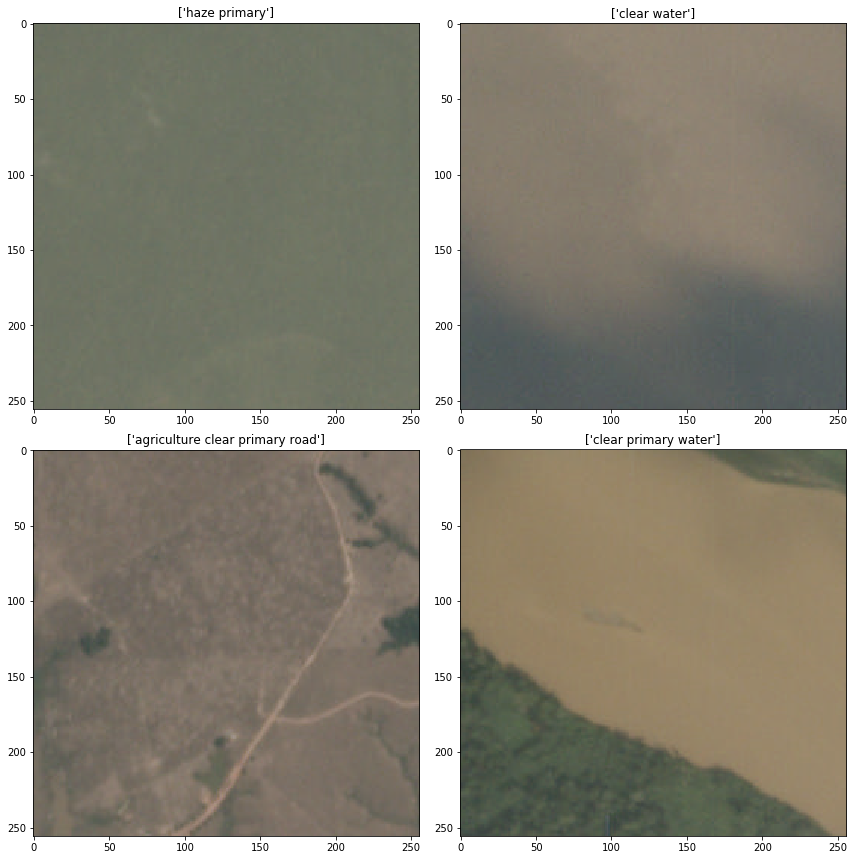

In [198]:
#Graph demonstration of three land type
plt.figure(figsize=(12,12))
land_list = ["primary","water","primary other", "primary water"]
j = 0
for i in land_list:
    plt.subplot(2,2,j+1)
    image_number = df.loc[df['land'] == i][3:4]['image_name'].values
    image_path = train_path1+image_number+".jpg"
    plt.imshow(plt.imread(image_path[0]))
    plt.tight_layout()
    plt.title(str(df[df.image_name == image_number[0]].tags.values))  
    j += 1

#### Counts of different tags

The majority pictures have 'Clear' weather and 'Primary' land type. There are very few pictures with no tag whatsoever

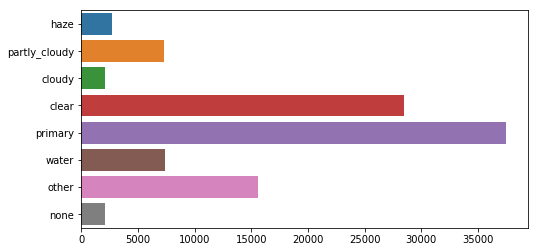

In [31]:
#Display counts of weather and land labels
df["combined_tags"] = df["weather"] + " " + df["land"]
labels = df['combined_tags'].apply(lambda x: x.split(' '))
all_tags = [item for sublist in list(labels.values) for item in sublist]
labels_s = pd.Series(all_tags).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=labels_s, y=labels_s.index, orient='h', order = ['haze', 'partly_cloudy', 'cloudy', 'clear','primary', 'water', 'other', 'none'])

#### Correlation between different tags

'Primary' land type has high correlation with all weather tags except for "Cloudy". All cloudy pcitures appear heavily correlate with 

"Water" land type is highly correlated with "Clear" tag.

In [14]:
#Display correlation between labels 
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

com = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        com[i, i2] = cy / c

data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
layout=go.Layout(height=600, width=600, title='Co-occurence matrix of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-com')

![](Correlation Matrix.JPG?raw=true)

#### A quick summary on color extraction

The mean color intensity is:  0.31
The mean color intensity is with haze reduction:  0.48
The mean color variance is:  0.003
The mean color variance is with haze reduction is:  0.204


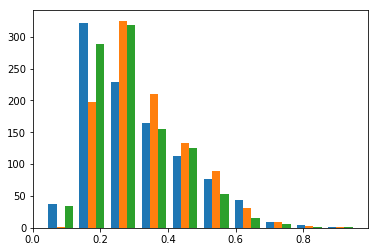

In [163]:
print('The mean color intensity is: ', round(jpg_stats[:,0:3].mean(), 2))
print('The mean color intensity is with haze reduction: ', round(jpg_stats[:,3:6].mean(), 2))
plt.hist(jpg_stats[:,0:3])

print('The mean color variance is: ', round(jpg_stats[:,11:14].mean(), 3))
print('The mean color variance is with haze reduction is: ', round(jpg_stats[:,14:17].mean(), 3))
# print('The mean color variance for haze reduced is: ', round(jpg_stats[:,14:17].mean(), 3))

#### A quick summary of edge extraction

(array([  2.,   4.,  18.,  52., 487., 383.,  41.,   6.,   4.,   3.]),
 array([-8.43849892e-03, -6.73628413e-03, -5.03406934e-03, -3.33185455e-03,
        -1.62963976e-03,  7.25750323e-05,  1.77478982e-03,  3.47700461e-03,
         5.17921941e-03,  6.88143420e-03,  8.58364899e-03]),
 <a list of 10 Patch objects>)

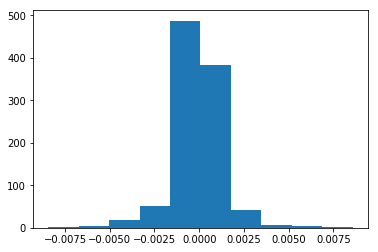

In [164]:
plt.hist(edge_stats[:,0])

(array([  1.,   4.,  18., 151., 736.,  62.,  21.,   2.,   3.,   2.]),
 array([-5.44015111, -4.16149438, -2.88283764, -1.60418091, -0.32552418,
         0.95313256,  2.23178929,  3.51044602,  4.78910276,  6.06775949,
         7.34641622]),
 <a list of 10 Patch objects>)

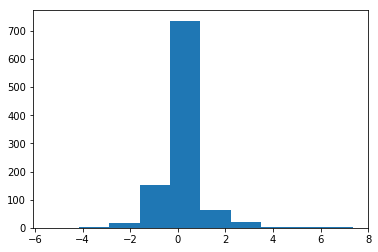

In [165]:
plt.hist(edge_stats[:,3:4])

#### Sample vegetation and water feature graph show

'partly_cloudy primary'

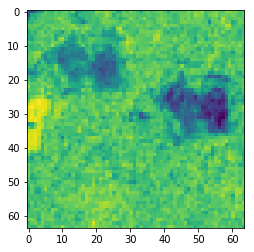

In [199]:
#Sample vegetation feature identification
plt.imshow(data_jpgs[99,:,:,9])

df['tags'][99]

We can see fairly clearly on the image what is forest and what is not. We should be able to use this to predict forest fairly accurately.